# GCN

## Install required packages.

In [27]:
import os
import torch
os.environ['TORCH'] = torch.__version__
os.environ['PYTHONWARNINGS'] = "ignore"
print(torch.__version__)
!pip install torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install git+https://github.com/pyg-team/pytorch_geometric.git

2.6.0+cu124
Looking in links: https://data.pyg.org/whl/torch-2.6.0+cu124.html
Looking in links: https://data.pyg.org/whl/torch-2.6.0+cu124.html
  Cloning https://github.com/pyg-team/pytorch_geometric.git to /tmp/pip-req-build-0fapqtxb
  Running command git clone --filter=blob:none --quiet https://github.com/pyg-team/pytorch_geometric.git /tmp/pip-req-build-0fapqtxb
  Resolved https://github.com/pyg-team/pytorch_geometric.git to commit 1b6455eb84bf9f94665b9ff475c175cb0e8b8efd
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [28]:
from torch_geometric.data import DataLoader
from torch_geometric.utils import from_networkx
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import pickle
import numpy as np
from sklearn.metrics import f1_score

## Load data

In [29]:
PATH = '' # os.path.join(Path.cwd().parents[2], '')

with open(os.path.join(PATH, "graphs_for_leak.pkl"), "rb") as f:
    mint_graphs, mint_labels = pickle.load(f)

with open(os.path.join(PATH, "graphs_for_limit.pkl"), "rb") as f:
    limit_graphs, limit_labels = pickle.load(f)

with open(os.path.join(PATH, "graphs_for_leak.pkl"), "rb") as f:
    leak_graphs, leak_labels = pickle.load(f)

### sample

In [30]:
import networkx as nx
import matplotlib.pyplot as plt

In [31]:
def show_sample(name, graphs, labels):
    for i, (graph, label) in enumerate(zip(graphs, labels)):
        nx.draw(graph, with_labels=True, node_color='lightblue', node_size=200, edge_color='gray', font_size=5)
        plt.title(f"Graph {i}, {name}: {label[0]}")
        plt.show()
        if i == 2:
            break

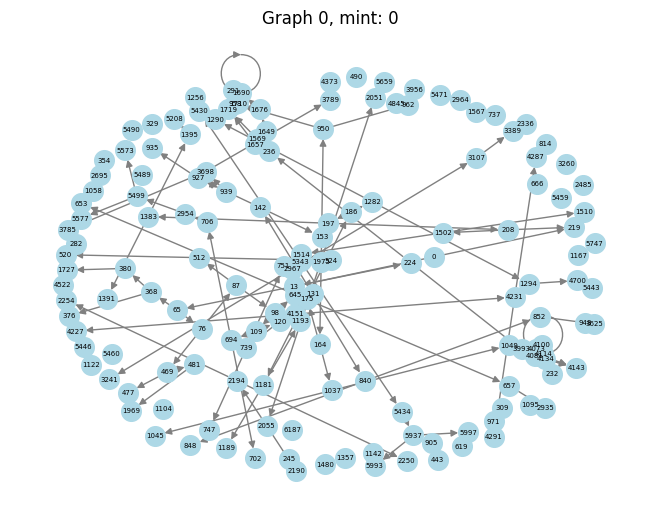

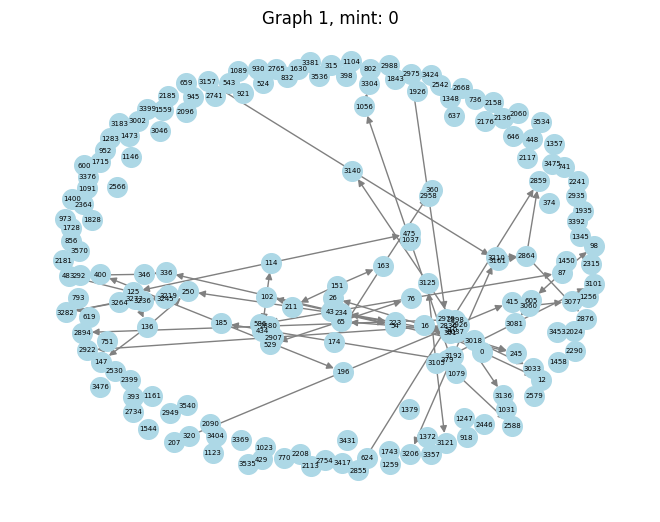

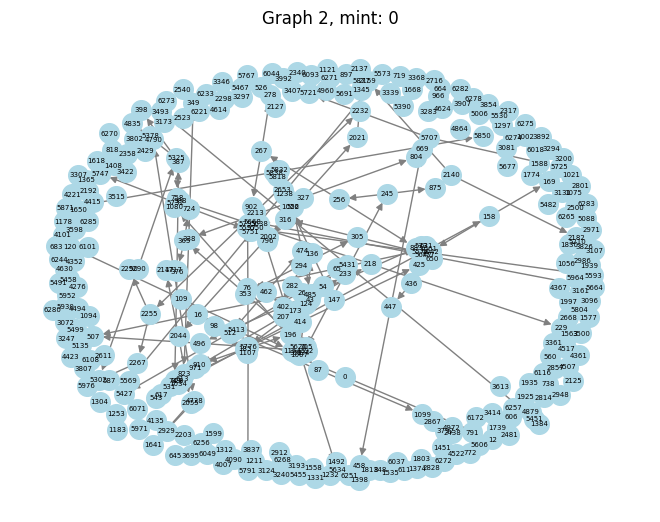

In [32]:
show_sample('mint', mint_graphs, mint_labels)

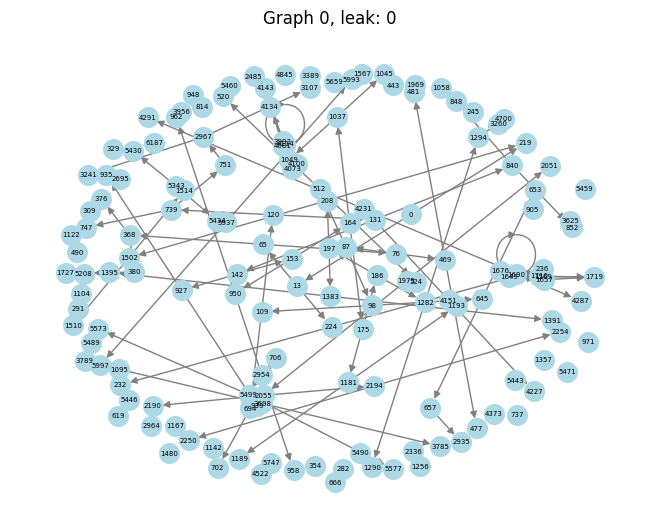

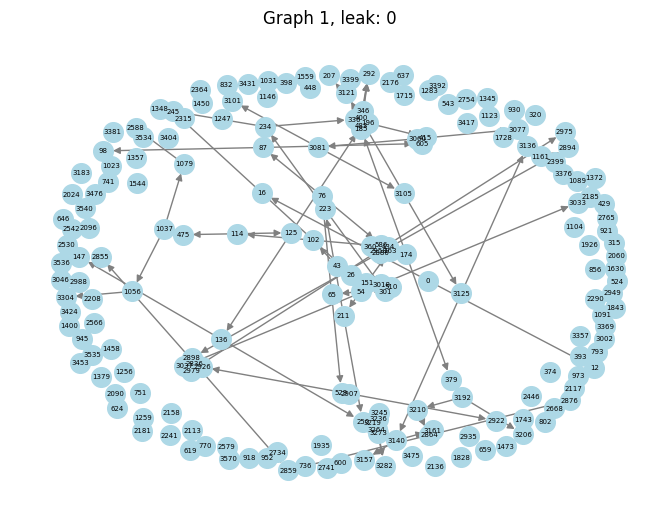

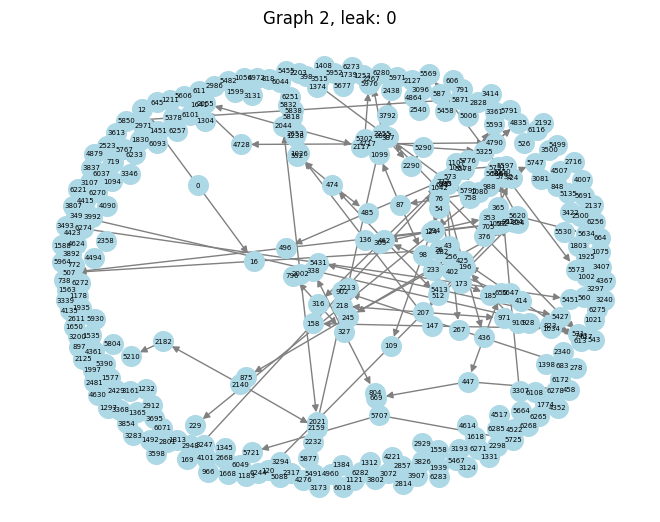

In [33]:
show_sample('leak', leak_graphs, leak_labels)

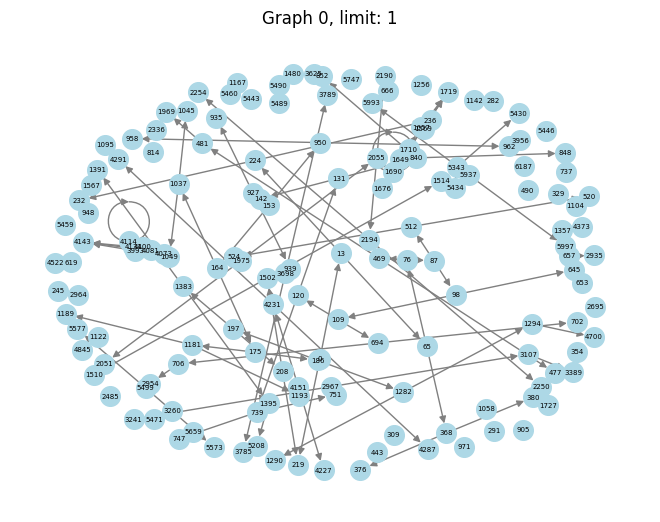

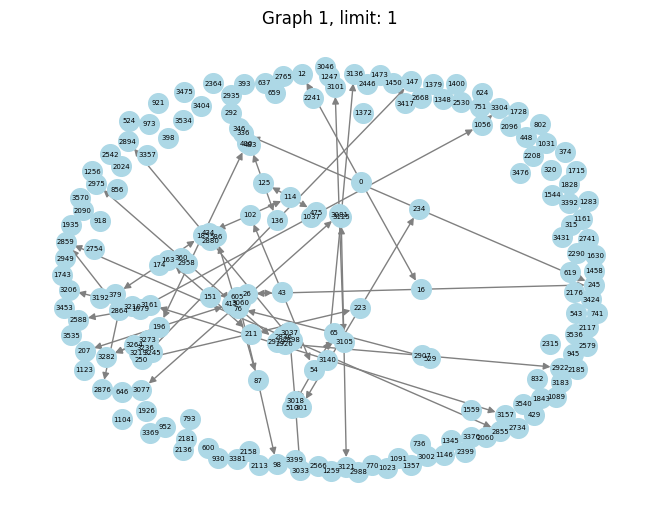

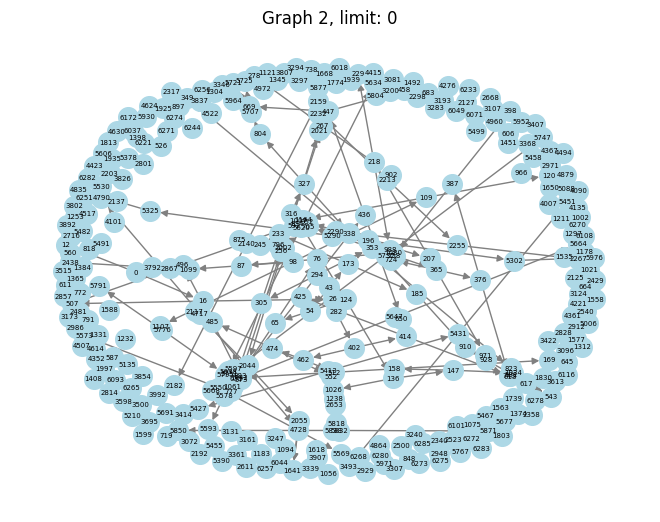

In [34]:
show_sample('limit', limit_graphs, limit_labels)

## Utils

In [35]:
def extract_graph_features(G):
    return {
        "num_nodes": G.number_of_nodes(),
        "num_edges": G.number_of_edges(),
        "avg_degree": sum(dict(G.degree()).values()) / G.number_of_nodes(),
        "density": nx.density(G),
        "connected_components": nx.number_weakly_connected_components(G),
        "avg_clustering": nx.average_clustering(G.to_undirected())
    }


In [36]:
def draw_confusion_matrix (model, y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    cm_display = ConfusionMatrixDisplay(cm)
    cm_display.plot(cmap=plt.cm.Blues,values_format='g')
    cm_display.ax_.set_title(model)
    plt.show()

In [37]:
def create_dataset(graphs, labels):
    dataset = []

    for graph, label in zip(graphs, labels):
        data = from_networkx(graph)
        label_value = [l for l in label]
        features = extract_graph_features(graph)
        degrees = torch.tensor([d for _, d in graph.degree()], dtype=torch.float).unsqueeze(1)

        # Concatenate node degrees with graph-level features for each node
        graph_features_tensor = torch.tensor(list(features.values()), dtype=torch.float).unsqueeze(0).repeat(data.num_nodes, 1)
        data.x = torch.cat([degrees, graph_features_tensor], dim=1)


        data.y = torch.tensor(label_value, dtype=torch.float).unsqueeze(0)
        # data.x = torch.tensor([d for _, d in graph.degree()]+ list(features.values()), dtype=torch.float).unsqueeze(1)
        # data.x = degrees
        print(data)
        dataset.append(data)
    return dataset

In [38]:
def tune_thresholds(y_true, y_pred_prob, metric='f1'):
    y_true = np.asarray(y_true)          # Fix: convert to NumPy
    y_pred_prob = np.asarray(y_pred_prob)

    best_thresholds = []
    best_scores = []

    for i in range(y_true.shape[1]):
        label_true = y_true[:, i]
        label_probs = y_pred_prob[:, i]  # Fix here too

        thresholds = np.linspace(0.0, 1.0, 101)
        scores = []

        for t in thresholds:
            label_pred = (label_probs >= t).astype(int)
            if metric == 'f1':
                score = f1_score(label_true, label_pred, zero_division=0)
            scores.append(score)

        best_t = thresholds[np.argmax(scores)]
        best_score = np.max(scores)

        best_thresholds.append(best_t)
        best_scores.append(best_score)

        print(f"Label {i}: Best threshold = {best_t:.2f}, Best {metric} = {best_score:.4f}")

    return best_thresholds, best_scores


In [39]:
def look_at_data(loader):
    for batch in loader:
        print(batch)
        print(batch.x.shape, batch.y.shape)
        break

## Model

In [40]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.loader import DataLoader

# Define the GNN Model
class MultiLabelGCN(nn.Module):
    def __init__(self, in_channels, hidden_channels, num_labels):
        super(MultiLabelGCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.lin = nn.Linear(hidden_channels, num_labels)

    def forward(self, x, edge_index, batch):
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = global_mean_pool(x, batch)
        x = torch.sigmoid(self.lin(x))  # Multi-label sigmoid activation
        return x

In [41]:
# Training Loop
def train(model, train_loader, optimizer, criterion):
    for epoch in range(1, 101):
        model.train()
        total_loss = 0
        for batch in train_loader:
            optimizer.zero_grad()
            out = model(batch.x, batch.edge_index, batch.batch)
            loss = criterion(out, batch.y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch}, Loss: {total_loss/len(train_loader):.4f}")

In [42]:
# Evaluation Function
def evaluate(name, loader):
    model.eval()
    y_true_all, y_prob_all = [], []

    with torch.no_grad():
        for batch in loader:
            out = model(batch.x, batch.edge_index, batch.batch)
            y_prob_all.append(out.cpu())          # Probabilities (sigmoid outputs)
            y_true_all.append(batch.y.cpu())      # Ground truth

    # Stack all predictions and targets
    y_true = torch.vstack(y_true_all).numpy()
    y_prob = torch.vstack(y_prob_all).numpy()

    # Tune thresholds only once
    best_thresholds, _ = tune_thresholds(y_true, y_prob)
    best_thresholds = np.array(best_thresholds)

    # Apply thresholds to binarize predictions
    y_pred = (y_prob > best_thresholds).astype(int)

    # Optional: draw confusion matrix for each label
    draw_confusion_matrix(name, y_true, y_pred)

    # Print classification report
    print(classification_report(y_true, y_pred, zero_division=0))


## Prepare Data

In [43]:
# Data Loader
mint_dataset = create_dataset(mint_graphs, mint_labels)
leak_dataset = create_dataset(leak_graphs, leak_labels)
limit_dataset = create_dataset(limit_graphs, limit_labels)
mint_loader = DataLoader(mint_dataset, batch_size=32, shuffle=True)
leak_loader = DataLoader(leak_dataset, batch_size=32, shuffle=True)
limit_loader = DataLoader(limit_dataset, batch_size=32, shuffle=True)

Data(edge_index=[2, 118], num_nodes=155, x=[155, 7], y=[1, 1])
Data(edge_index=[2, 96], num_nodes=194, x=[194, 7], y=[1, 1])
Data(edge_index=[2, 178], num_nodes=339, x=[339, 7], y=[1, 1])
Data(edge_index=[2, 78], num_nodes=113, x=[113, 7], y=[1, 1])
Data(edge_index=[2, 211], num_nodes=303, x=[303, 7], y=[1, 1])
Data(edge_index=[2, 158], num_nodes=377, x=[377, 7], y=[1, 1])
Data(edge_index=[2, 262], num_nodes=346, x=[346, 7], y=[1, 1])
Data(edge_index=[2, 184], num_nodes=177, x=[177, 7], y=[1, 1])
Data(edge_index=[2, 105], num_nodes=150, x=[150, 7], y=[1, 1])
Data(edge_index=[2, 415], num_nodes=489, x=[489, 7], y=[1, 1])
Data(edge_index=[2, 235], num_nodes=299, x=[299, 7], y=[1, 1])
Data(edge_index=[2, 180], num_nodes=218, x=[218, 7], y=[1, 1])
Data(edge_index=[2, 172], num_nodes=205, x=[205, 7], y=[1, 1])
Data(edge_index=[2, 305], num_nodes=1011, x=[1011, 7], y=[1, 1])
Data(edge_index=[2, 149], num_nodes=210, x=[210, 7], y=[1, 1])
Data(edge_index=[2, 154], num_nodes=189, x=[189, 7], y=

In [44]:
look_at_data(mint_loader)

DataBatch(edge_index=[2, 5602], num_nodes=9691, x=[9691, 7], y=[32, 1], batch=[9691], ptr=[33])
torch.Size([9691, 7]) torch.Size([32, 1])


In [45]:
look_at_data(leak_loader)

DataBatch(edge_index=[2, 5753], num_nodes=10841, x=[10841, 7], y=[32, 1], batch=[10841], ptr=[33])
torch.Size([10841, 7]) torch.Size([32, 1])


In [46]:
look_at_data(limit_loader)

DataBatch(edge_index=[2, 5013], num_nodes=9184, x=[9184, 7], y=[32, 1], batch=[9184], ptr=[33])
torch.Size([9184, 7]) torch.Size([32, 1])


## Train & Evaluarion

### Mint

In [47]:
# Split your dataset
train_data, test_data = train_test_split(mint_dataset, test_size=0.2, random_state=42)

train_loader = DataLoader(train_data, batch_size=8, shuffle=True)
test_loader = DataLoader(test_data, batch_size=8, shuffle=False)

# Initialize Model, Loss, Optimizer
# in_channels should be the number of features per node now.
model = MultiLabelGCN(in_channels=7, hidden_channels=64, num_labels=1)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

Label 0: Best threshold = 0.00, Best f1 = 0.7200


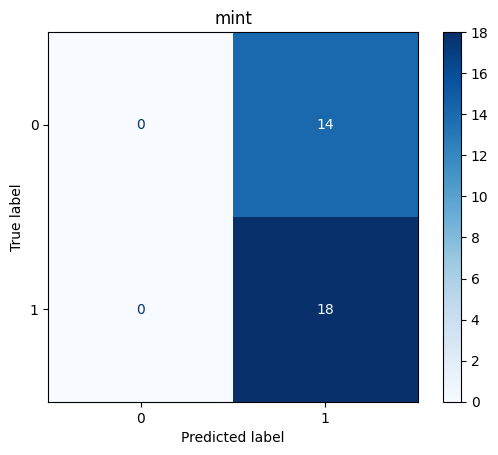

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        14
         1.0       0.56      1.00      0.72        18

    accuracy                           0.56        32
   macro avg       0.28      0.50      0.36        32
weighted avg       0.32      0.56      0.40        32



In [48]:
# Run Evaluation
evaluate('mint', test_loader)

### Leak

In [49]:
# Split your dataset
train_data, test_data = train_test_split(leak_dataset, test_size=0.2, random_state=42)

train_loader = DataLoader(train_data, batch_size=8, shuffle=True)
test_loader = DataLoader(test_data, batch_size=8, shuffle=False)

# Initialize Model, Loss, Optimizer
# in_channels should be the number of features per node now.
model = MultiLabelGCN(in_channels=7, hidden_channels=64, num_labels=1)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

Label 0: Best threshold = 0.00, Best f1 = 0.7200


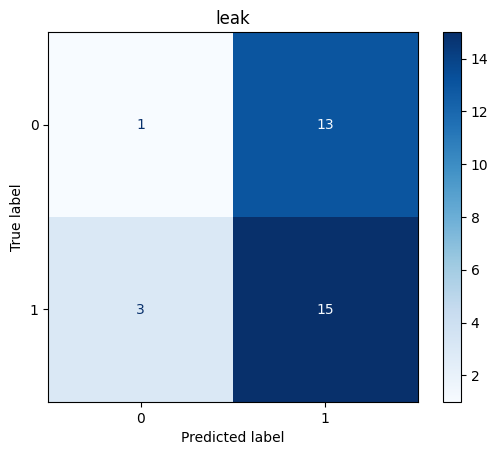

              precision    recall  f1-score   support

         0.0       0.25      0.07      0.11        14
         1.0       0.54      0.83      0.65        18

    accuracy                           0.50        32
   macro avg       0.39      0.45      0.38        32
weighted avg       0.41      0.50      0.42        32



In [50]:
# Run Evaluation
evaluate('leak', test_loader)

### Limit

In [51]:
# Split your dataset
train_data, test_data = train_test_split(limit_dataset, test_size=0.2, random_state=42)

train_loader = DataLoader(train_data, batch_size=8, shuffle=True)
test_loader = DataLoader(test_data, batch_size=8, shuffle=False)

# Initialize Model, Loss, Optimizer
# in_channels should be the number of features per node now.
model = MultiLabelGCN(in_channels=7, hidden_channels=64, num_labels=1)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

Label 0: Best threshold = 0.13, Best f1 = 0.8889


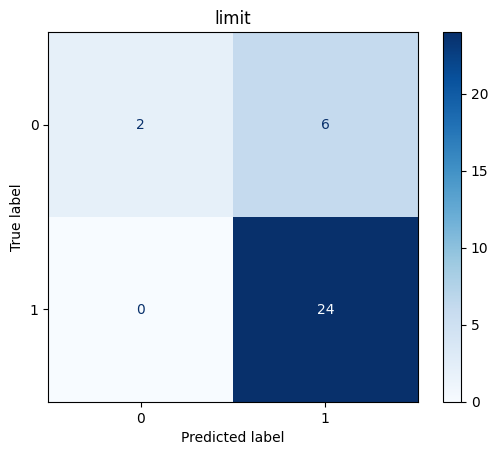

              precision    recall  f1-score   support

         0.0       1.00      0.25      0.40         8
         1.0       0.80      1.00      0.89        24

    accuracy                           0.81        32
   macro avg       0.90      0.62      0.64        32
weighted avg       0.85      0.81      0.77        32



In [52]:
# Run Evaluation
evaluate('limit', test_loader)